# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
%matplotlib inline

#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

import rdtools

/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. <b>Standardize</b>

Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical columns.



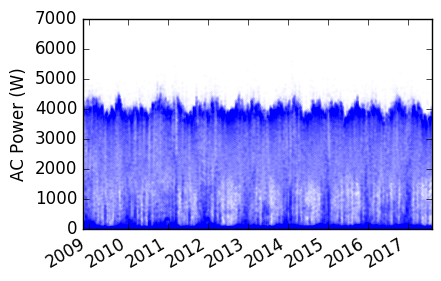

In [2]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
df = df.rename(columns = {
    '12 BP Solar - Active Power (kW)':'power',
    '12 BP Solar - Wind Speed (m/s)': 'wind',
    '12 BP Solar - Weather Temperature Celsius (\xc2\xb0C)': 'Tamb',
    '12 BP Solar - Global Horizontal Radiation (W/m\xc2\xb2)': 'ghi',
    '12 BP Solar - Diffuse Horizontal Radiation (W/m\xc2\xb2)': 'dhi'
})
df.index = pd.to_datetime(df.Timestamp)
df.index = df.index.tz_localize('Australia/North', ambiguous = 'infer') # TZ is required for irradiance transposition

# Chage power to watts
df['power'] = df.power * 1000.0 
# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# And then set the frequency of the dataframe
df = df.resample(freq).asfreq()

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.power, 'o', alpha = 0.01)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

# Calculate energy yield in kWh
df['energy'] = df.power * pd.to_timedelta(df.power.index.freq).total_seconds()/(3600.0)

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

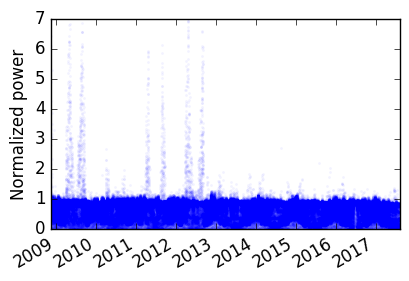

In [3]:
# Metadata
lat = -23.762028
lon = 133.874886
azimuth = 0
tilt = 20
pdc = 5100.0 # DC rating in watts

meta = {"altitude":0,
       "latitude": lat,
       "longitude": lon,
       "Name": "Alice Springs",
       "State": "n/a",
       "TZ": 8.5}

# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(tilt, df.dhi)

sun = pvlib.solarposition.get_solarposition(df.index, lat, lon)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(tilt, azimuth, sun.zenith, sun.azimuth, df.dni)

df['poa'] = beam + sky

# Calculate temperature
df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model = 'open_rack_cell_polymerback')
df['Tcell'] = df_temp.temp_cell

pv = pvlib.pvsystem.systemdef(meta, surface_tilt=tilt, surface_azimuth=azimuth, 
                              albedo=0.2, modules_per_string=6, strings_per_inverter=5)


pvwatts_kws = {"poa_global" : df.poa,
              "P_ref" : pdc,
              "T_cell" :df.Tcell,
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : -0.005}

normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)

df['normalized'] = normalized
df['insolation'] = insolation


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


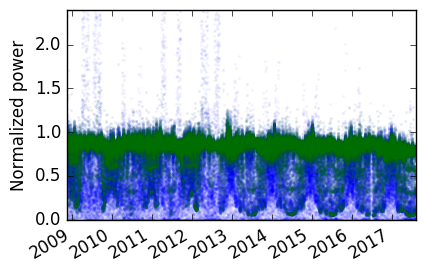

In [4]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future
filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa>200))

filtered = df[filter_criteria]
filtered = filtered[['insolation', 'normalized']]


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 4. <b>Aggregate</b>

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

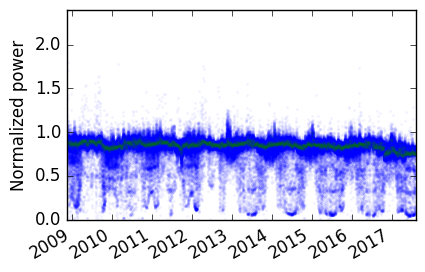

In [5]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation)

# Plot the normalized and filtered power time series along with the aggregation
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 5. <b>Degradation calculation</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.


In [6]:
ols_rd, ols_ci, ols_info = rdtools.degradation_ols(daily)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (ols_rd, ols_ci[0], ols_ci[1])

yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily)
print '''The degradation rate calculated with year on year is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (yoy_rd, yoy_ci[0], yoy_ci[1])

The degradation rate calculated with ols is -0.84 %/year
with a confidence interval of -0.86 to -0.81 %/year

The degradation rate calculated with year on year is -0.92 %/year
with a confidence interval of -1.01 to -0.84 %/year



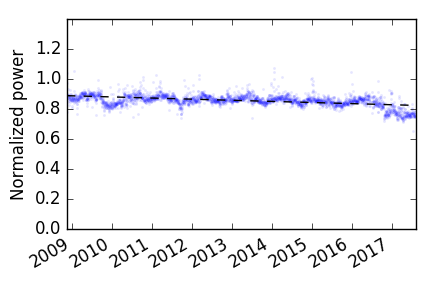

In [7]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

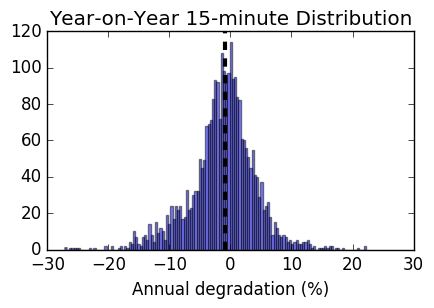

In [8]:
# Plot the year-on-year distribution
# Note that the uncertainty is from bootstrapping the median
# not the standard deviation of the plotted distribution
yoy_values = yoy_info['YoY_values']
plt.hist(yoy_values, alpha=0.5, label='YOY', bins=int(yoy_values.__len__()/20))
plt.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
#plt.legend(loc='upper right')
plt.title('Year-on-Year 15-minute Distribution')   
plt.tight_layout(w_pad=1, h_pad=2.0)
plt.xlabel('Annual degradation (%)');